In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import geopandas as gpd
import geocoder
import folium
import requests
import time
import math

In [3]:
# Notebook Styling 
# sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

The data set below is available on this [City of Chicago Data Portal page](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), but as the file is approximately 1 GB, I've excluded it from this repo.

[Chicago Community Area Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

[Chicago Police Beat Geojson](https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74)

[Chicago 2010 Census Block Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Blocks-2010/mfzt-js4n)

In [4]:
def process_chicrimes(chi_crimes):
    chi_crimes['Date'] = pd.to_datetime(chi_crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes['Updated On'] = pd.to_datetime(chi_crimes['Updated On'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes.drop(['Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
    chi_crimes['Block'] = chi_crimes['Block'].astype('category')
    chi_crimes['IUCR'] = chi_crimes['IUCR'].astype('category')
    chi_crimes['Primary Type'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Description'] = chi_crimes['Description'].astype('category')
    chi_crimes['Location Description'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Beat'] = chi_crimes['Beat'].astype(int)
    chi_crimes['District'] = chi_crimes['District'].astype('category')
    chi_crimes['Ward'] = chi_crimes['Ward'].astype('category')
    chi_crimes['Community Area'] = chi_crimes['Community Area'].astype('category')
    chi_crimes['FBI Code'] = chi_crimes['FBI Code'].astype('category')
    chi_crimes['Hour'] = chi_crimes['Date'].dt.hour
    chi_crimes['Week'] = chi_crimes['Date'].dt.weekofyear
    chi_crimes['Day'] = chi_crimes['Date'].dt.dayofyear
    chi_crimes['Weekday'] = chi_crimes['Date'].dt.dayofweek
    chi_crimes['Month'] = chi_crimes['Date'].dt.month
    chi_crimes['Hour'] = chi_crimes['Hour'].astype('category')
    chi_crimes['Week'] = chi_crimes['Week'].astype('category')
    chi_crimes['Day'] = chi_crimes['Day'].astype('category')
    chi_crimes['Weekday'] = chi_crimes['Weekday'].astype('category')
    chi_crimes['Month'] = chi_crimes['Month'].astype('category')
    return chi_crimes

In [5]:
CSV_PATH = os.path.join('data', 'big', 'Crimes_-_2001_to_present.csv')
crime_dtypes = {'District':str,
                'Ward':str, 
                'Community Area':str}
chi_crimes = pd.read_csv(CSV_PATH, dtype=crime_dtypes, encoding='latin1') 
chi_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,011,28,25,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,007,15,67,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,002,4,39,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,002,3,40,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,011,28,25,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


In [6]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784163 entries, 0 to 6784162
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                object
Ward                    object
Community Area          object
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(4), int64(3), object(13)
memory usage: 1.0+ GB


In [7]:
chi_crimes = process_chicrimes(chi_crimes)

In [8]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784163 entries, 0 to 6784162
Data columns (total 24 columns):
ID                      int64
Case Number             object
Date                    datetime64[ns]
Block                   category
IUCR                    category
Primary Type            category
Description             category
Location Description    category
Arrest                  bool
Domestic                bool
Beat                    int32
District                category
Ward                    category
Community Area          category
FBI Code                category
Year                    int64
Updated On              datetime64[ns]
Latitude                float64
Longitude               float64
Hour                    category
Week                    category
Day                     category
Weekday                 category
Month                   category
dtypes: bool(2), category(14), datetime64[ns](2), float64(2), int32(1), int64(2), object(1)
memory usage

In [9]:
chi_crimes.loc[:,'Primary Type'].value_counts()

THEFT                                1427332
BATTERY                              1238778
CRIMINAL DAMAGE                       775204
NARCOTICS                             712700
ASSAULT                               421167
OTHER OFFENSE                         420879
BURGLARY                              389632
MOTOR VEHICLE THEFT                   315719
DECEPTIVE PRACTICE                    265288
ROBBERY                               257023
CRIMINAL TRESPASS                     194278
WEAPONS VIOLATION                      71444
PROSTITUTION                           68418
PUBLIC PEACE VIOLATION                 47988
OFFENSE INVOLVING CHILDREN             45677
CRIM SEXUAL ASSAULT                    27348
SEX OFFENSE                            25235
INTERFERENCE WITH PUBLIC OFFICER       15309
GAMBLING                               14427
LIQUOR LAW VIOLATION                   14082
ARSON                                  11202
HOMICIDE                                9505
KIDNAPPING

In [10]:
query = chi_crimes.loc[:,'Description'].value_counts()
query[(query > 30000) & (query < np.inf)]

SIMPLE                            800054
$500 AND UNDER                    550320
DOMESTIC BATTERY SIMPLE           520593
TO VEHICLE                        376613
TO PROPERTY                       356720
OVER $500                         350604
POSS: CANNABIS 30GMS OR LESS      276782
FORCIBLE ENTRY                    263933
AUTOMOBILE                        247609
FROM BUILDING                     228517
RETAIL THEFT                      168796
TELEPHONE THREAT                  135003
TO LAND                           120276
POSS: CRACK                       119291
UNLAWFUL ENTRY                    103494
HARASSMENT BY TELEPHONE           100749
AGGRAVATED: OTHER DANG WEAPON      93641
POSS: HEROIN(WHITE)                92321
ARMED: HANDGUN                     91039
STRONGARM - NO WEAPON              89127
AGGRAVATED: HANDGUN                84649
AGGRAVATED:KNIFE/CUTTING INSTR     56917
CREDIT CARD FRAUD                  53640
UNLAWFUL POSS OF HANDGUN           47548
SOLICIT ON PUBLI

In [11]:
chi_crimes.loc[chi_crimes['Primary Type'] == 'HOMICIDE', 'Description'].unique()

[FIRST DEGREE MURDER, RECKLESS HOMICIDE, INVOLUNTARY MANSLAUGHTER]
Categories (3, object): [FIRST DEGREE MURDER, RECKLESS HOMICIDE, INVOLUNTARY MANSLAUGHTER]

In [12]:
def plot_monthly_and_yearly_rates(df, crime, col='Primary Type', max_year=2018, figsize=(12,4)):
    with sns.axes_style("darkgrid"):
        df = df[(df['Year'] <= max_year) & (df[col] == crime)]
        df.set_index('Date', inplace=True)
        
        fig, ax = plt.subplots(sharex=True, figsize=figsize)
        mo_df = df[['ID']].groupby([df.index.year, df.index.month]).count()
        mo_df.plot(ax=ax, kind='line', legend=None)
        ax.set_title('Monthly (top) and Annual (bot) {} in Chicago'.format(crime), fontsize=16)
        ax.set_ylabel('{} per Month'.format(crime), fontsize=14)
        ax.set_xlabel('', fontsize=14)
        ax.set_ylim([0, mo_df['ID'].max() * 1.1])
        plt.tight_layout()
        
        fig, ax = plt.subplots(sharex=True, figsize=(12,4))
        yr_df = df[['ID']].groupby([df.index.year]).count()
        yr_df.plot(ax=ax, legend=None)
        ax.set_ylabel('{} per Year'.format(crime), fontsize=14)
        ax.set_xlabel('Year', fontsize=16)
        ax.set_ylim([0, yr_df['ID'].max() * 1.1])
        plt.tight_layout()

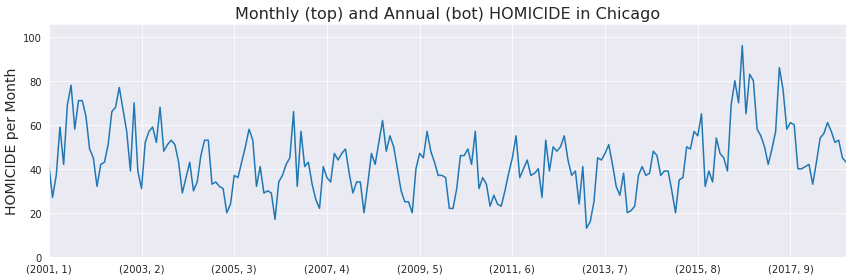

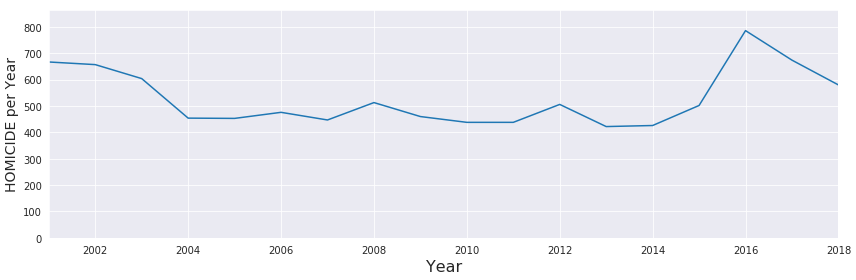

In [13]:
plot_monthly_and_yearly_rates(chi_crimes, 'HOMICIDE')

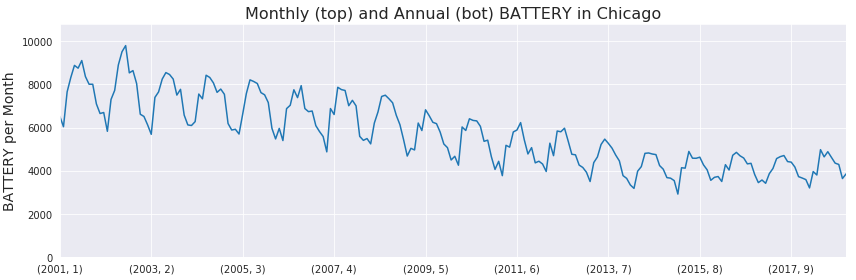

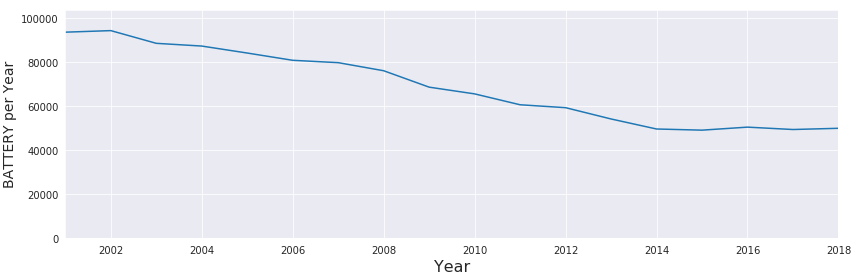

In [14]:
plot_monthly_and_yearly_rates(chi_crimes, 'BATTERY')

In [15]:
chi_crimes[chi_crimes['Description'] == 'TO VEHICLE'].head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Week,Day,Weekday,Month
10,10000105,HY189984,2015-03-18 21:30:00,130XX S DR MARTIN LUTHER KING JR DR,1320,CRIMINAL DAMAGE,TO VEHICLE,CRIMINAL DAMAGE,False,False,533,005,9,54,14,2015,2018-02-10 15:50:01,41.658138,-87.613673,21,12,77,2,3
77,10000203,HY190151,2015-03-19 01:00:00,020XX N PULASKI RD,1320,CRIMINAL DAMAGE,TO VEHICLE,CRIMINAL DAMAGE,False,False,2525,025,30,20,14,2015,2018-02-10 15:50:01,41.918321,-87.726596,1,12,78,3,3
92,10000241,HY188049,2015-03-15 20:45:00,014XX N HARDING AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,CRIMINAL DAMAGE,False,False,2535,025,30,23,14,2015,2018-02-10 15:50:01,41.906867,-87.725213,20,11,74,6,3


In [16]:
def get_timescales(span, x=False):
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    weeks = np.arange(0,53).tolist()
    weekdays = ['Sun', 'Sat', 'Fri', 'Thu', 'Wed', 'Tue', 'Mon']
    hours = np.arange(23,-1,-1).tolist()
    if span == 'Month':
        return (span, months)
    elif span == 'Hour':
        return (span, hours)
    elif span == 'Week':
        return (span, weeks)
    else:
        if x:
            weekdays.reverse()
        return ('Weekday', weekdays)

def plot_crime_freq_heatmap(crime_desc, x_ax, y_ax, year, df=chi_crimes, figsize=(14,6), cmap='YlGn', col='Primary Type'):    
    x_ax, x_labs = get_timescales(x_ax, True)
    y_ax, y_labs = get_timescales(y_ax)
    tmp = df[(df[col] == crime_desc) &
             (df['Year'] == year)][[col, y_ax, x_ax]] 
    tmp1 = tmp.pivot_table(index=y_ax, columns=x_ax, values=col, aggfunc=['count'])
    tmp1.sort_index(ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(tmp1, ax=ax, annot=False, fmt='d', cmap=cmap)
    ax.xaxis.set_ticklabels(x_labs, fontsize=14)
    ax.yaxis.set_ticklabels(y_labs, fontsize=12, rotation=0)
    ax.set_xlabel(x_ax, fontsize=14)
    ax.set_ylabel(y_ax, fontsize=14)
    ax.set_title('Frequency of crime: "{}" by {} and {} for {}'
                 .format(crime_desc, y_ax, x_ax, year), fontsize=16)
    plt.show()

In [17]:
ZIP_SHP_PATH = os.path.join('zip://', 'data', 'Boundaries - Police Beats (current).zip')
beats = gpd.read_file(ZIP_SHP_PATH)
beats['beat_num'] = beats['beat_num'].astype(int)
# ax = beats.plot(figsize=(10,10))
# ax.grid('off')

In [18]:
def map_counts(df_, col_val, start_date='2001-01-01', end_date='2019-01-03', gdf=beats, val='Arrest', col='Primary Type', my_cmap='YlGn', scale=0.6, tight=True, figsize=(10,10)):
    df = df_[(df_['Date'] >= start_date) & (df_['Date'] <= end_date)].copy()
    fig, ax = plt.subplots(figsize=figsize)
    counts = df.pivot_table(index='Beat', values=val, columns=col, aggfunc='count', fill_value=0)[[col_val]]
    map_df = pd.merge(left=gdf, right=counts, right_index=True, left_on='beat_num')
    vmin = map_df[col_val].min()
    vmax = map_df[col_val].max()
    
    base = gdf.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
    map_df.plot(column=col_val, ax=base, cmap=my_cmap)
    _ = ax.axis('off')
    _ = ax.set_title('Counts of {} per police beat\nfrom {} to {}'.format(col_val, start_date, end_date),
                     fontdict={'fontsize': '25', 'fontweight':'3'})
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    if tight:
        plt.tight_layout()

## Crime Description: Domestic Battery Simple

Looks like there was some issue recording domestic battery crimes near the beginning of this data span.

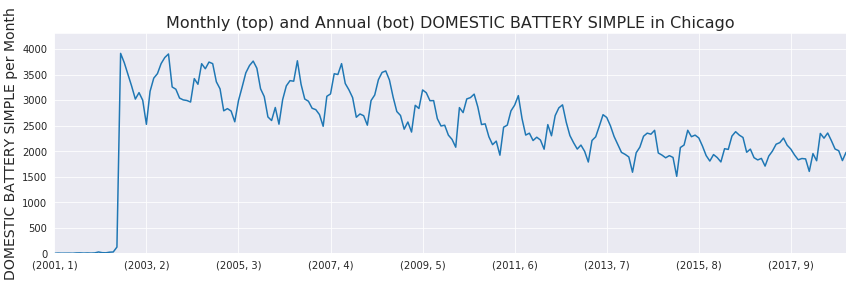

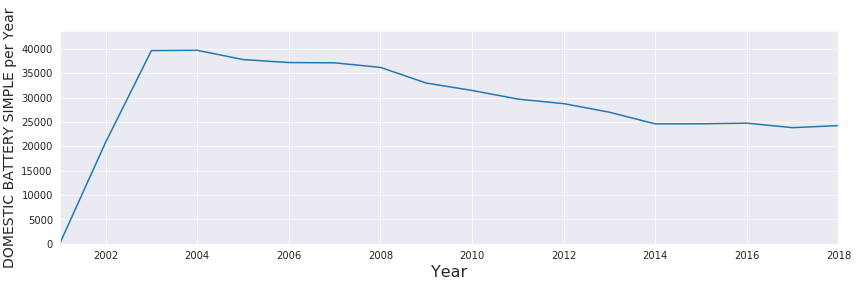

In [19]:
plot_monthly_and_yearly_rates(chi_crimes, 'DOMESTIC BATTERY SIMPLE', col='Description')

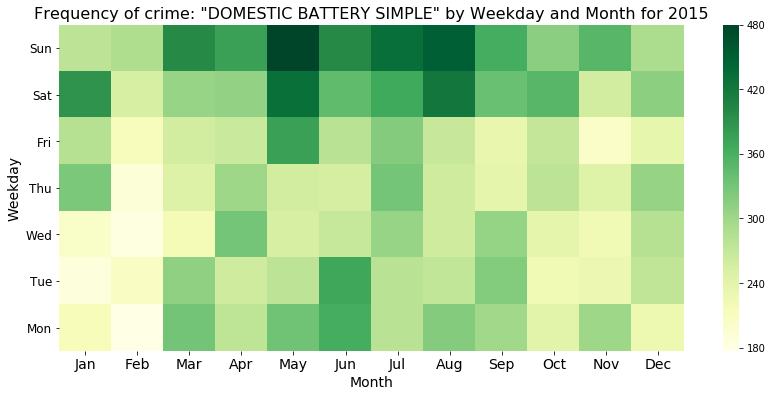

In [20]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Month', 'Weekday', 2015, col='Description')

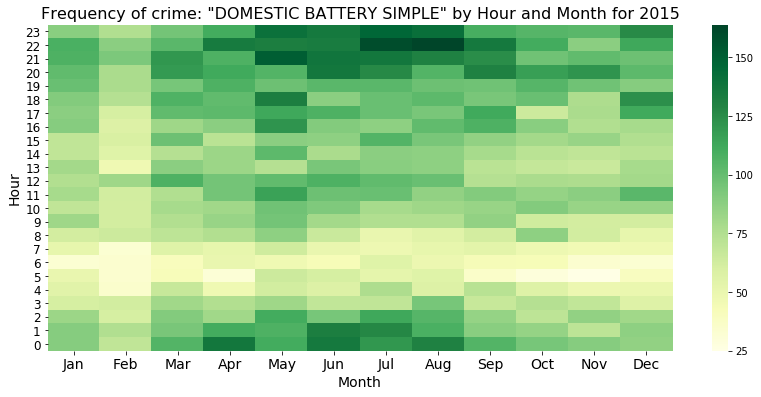

In [21]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Month', 'Hour', 2015, col='Description')

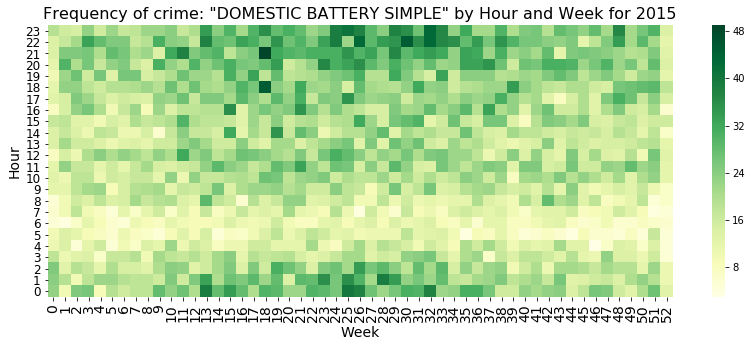

In [22]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Week', 'Hour', 2015, figsize=(14,5), col='Description')

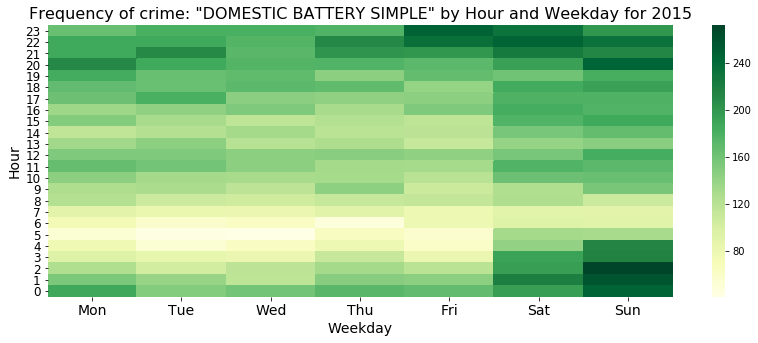

In [23]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Weekday', 'Hour', 2015, figsize=(14,5), col='Description')

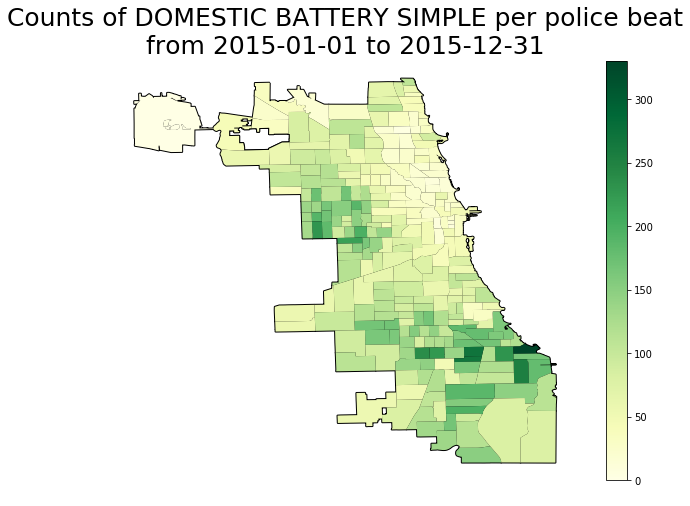

In [24]:
map_counts(chi_crimes, 'DOMESTIC BATTERY SIMPLE', '2015-01-01', '2015-12-31', scale=0.6, figsize=(10,10), col='Description')

## Crime Primary Type: Homicide

Looks like there was some issue recording domestic battery crimes near the beginning of this data span.

In [25]:
crime = 'HOMICIDE'

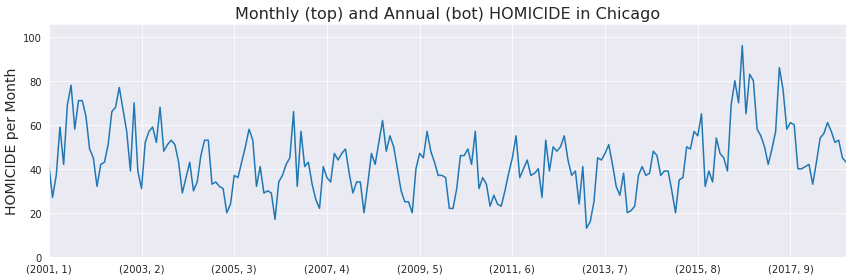

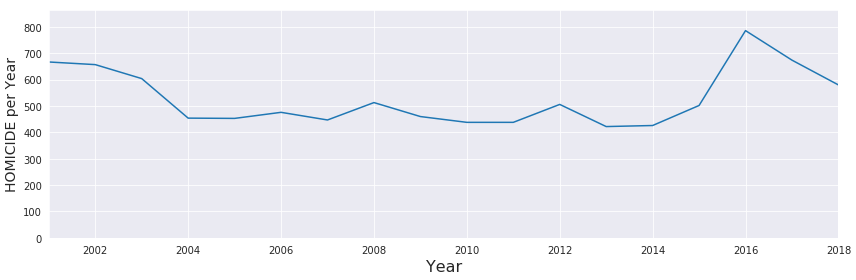

In [26]:
plot_monthly_and_yearly_rates(chi_crimes, crime)

In [27]:
year_of_interest = 2016

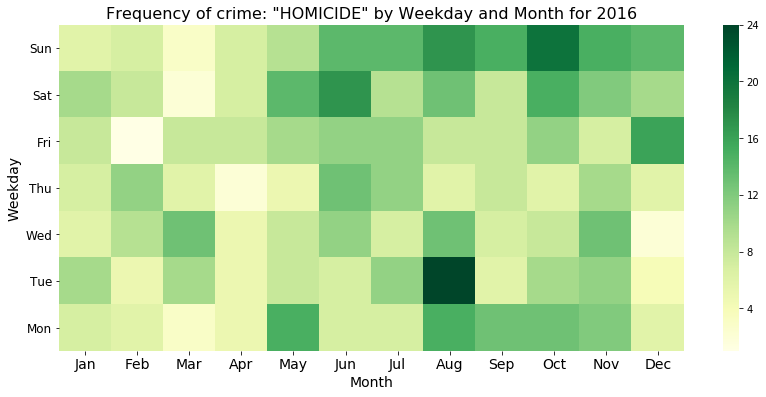

In [28]:
plot_crime_freq_heatmap(crime, 'Month', 'Weekday', year_of_interest)

Luckily homicides are sufficiently sparse that the heatmap of homicides by hour and week is splotchy and unpleasant to look at. 

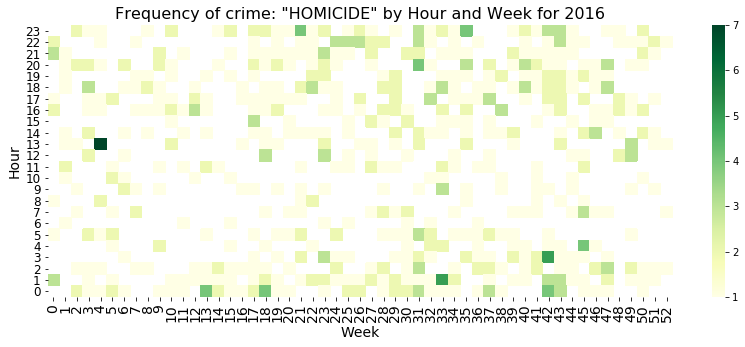

In [30]:
plot_crime_freq_heatmap(crime, 'Week', 'Hour', year_of_interest, figsize=(14,5))

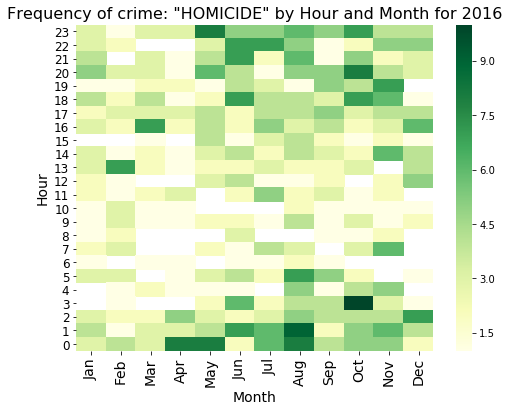

In [39]:
plot_crime_freq_heatmap(crime, 'Month', 'Hour', year_of_interest, figsize=(8,6))

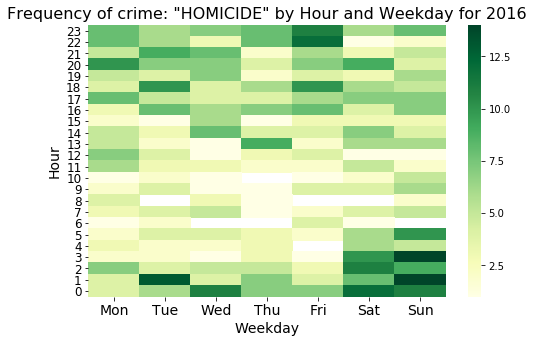

In [41]:
plot_crime_freq_heatmap(crime, 'Weekday', 'Hour', year_of_interest, figsize=(8,5))

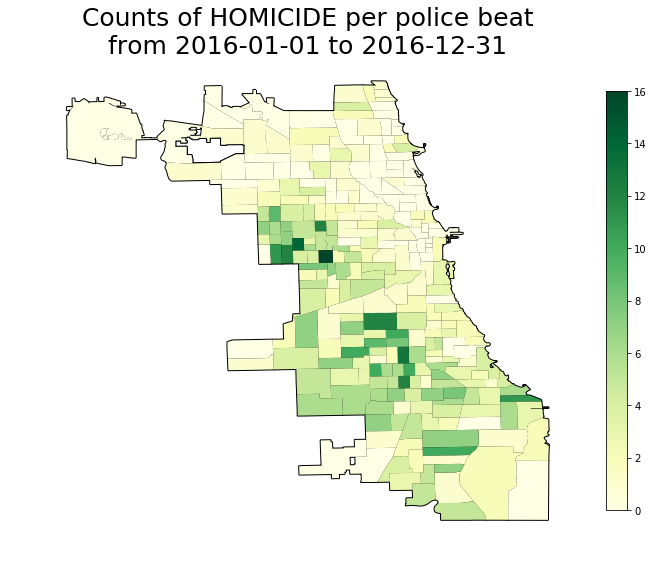

In [42]:
map_counts(chi_crimes, crime, '{}-01-01'.format(year_of_interest), '{}-12-31'.format(year_of_interest), scale=0.6, figsize=(10,10))

## Crime Primary Type: Narcotics

Looks like there was some issue recording domestic battery crimes near the beginning of this data span.

In [43]:
crime = 'NARCOTICS'

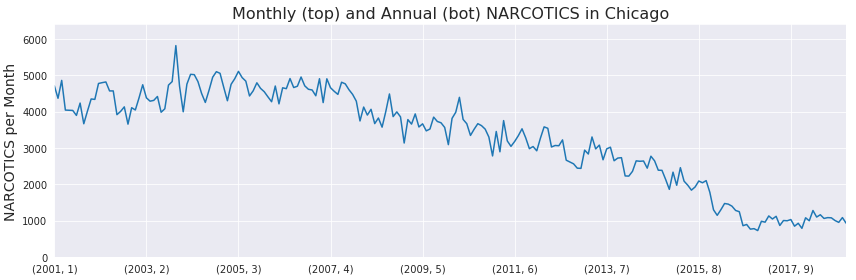

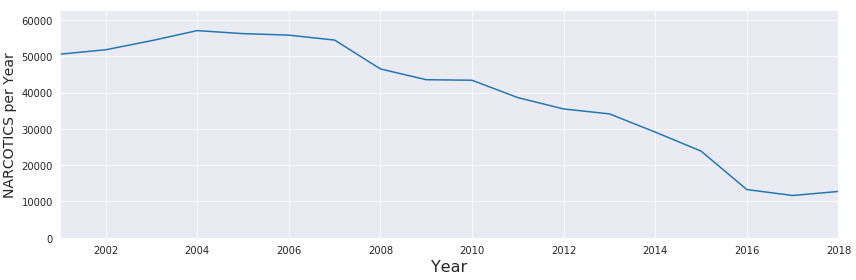

In [44]:
plot_monthly_and_yearly_rates(chi_crimes, crime)

Considering what we saw in the Homicide exploration, it would make sense that enforcement of narcotics crimes would decrease as officers are pulled off to work homicides.

In [45]:
year_of_interest = 2016

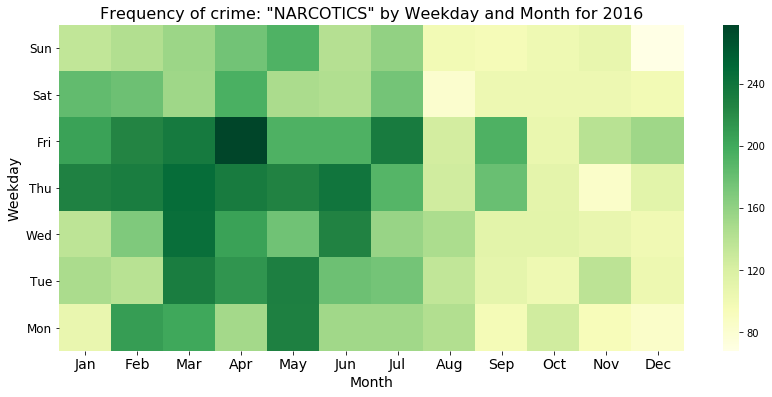

In [46]:
plot_crime_freq_heatmap(crime, 'Month', 'Weekday', year_of_interest)

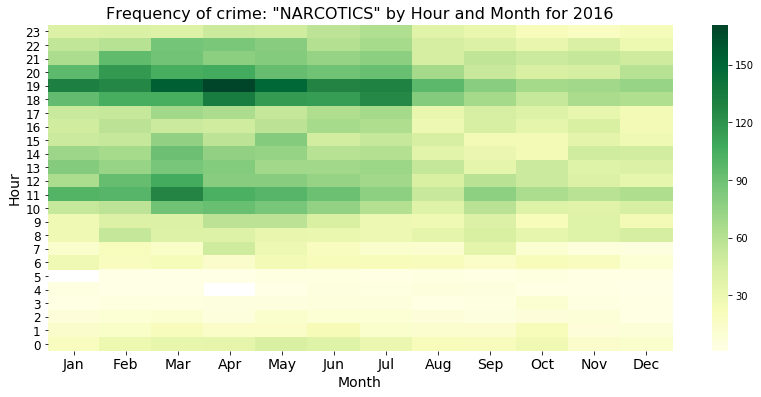

In [48]:
plot_crime_freq_heatmap(crime, 'Month', 'Hour', year_of_interest)

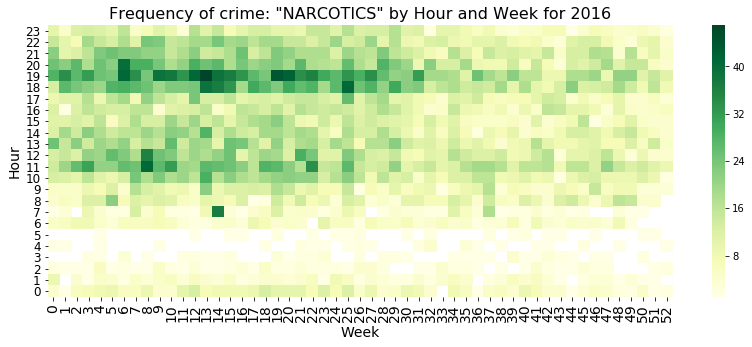

In [49]:
plot_crime_freq_heatmap(crime, 'Week', 'Hour', year_of_interest, figsize=(14,5))

That's interesting. It makes sense that Friday evening would be a prime time for narcotics arrests, but it seems strange that 

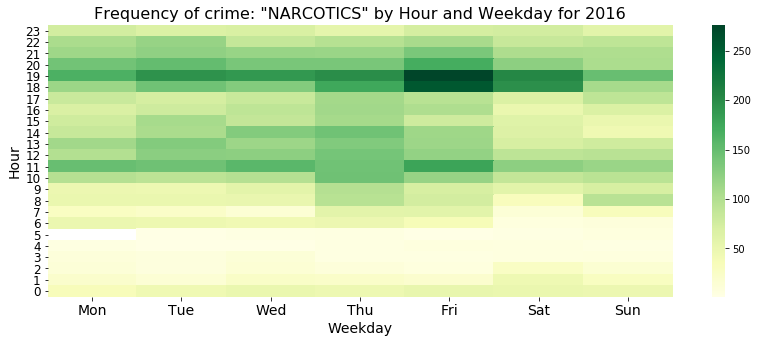

In [50]:
plot_crime_freq_heatmap(crime, 'Weekday', 'Hour', year_of_interest, figsize=(14,5))

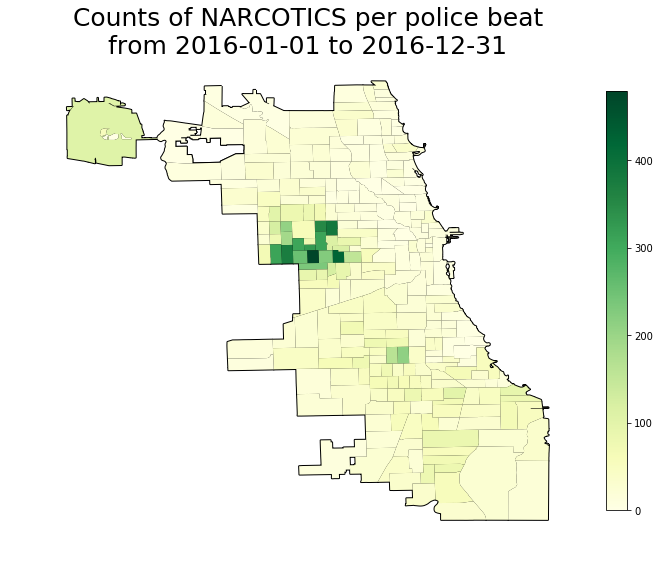

In [51]:
map_counts(chi_crimes, crime, '{}-01-01'.format(year_of_interest), '{}-12-31'.format(year_of_interest), scale=0.6, figsize=(10,10))

In [40]:
plot_crime_freq_heatmap('POSS: CRACK', 'Month', 'Hour', months, hours, 2003)

NameError: name 'months' is not defined

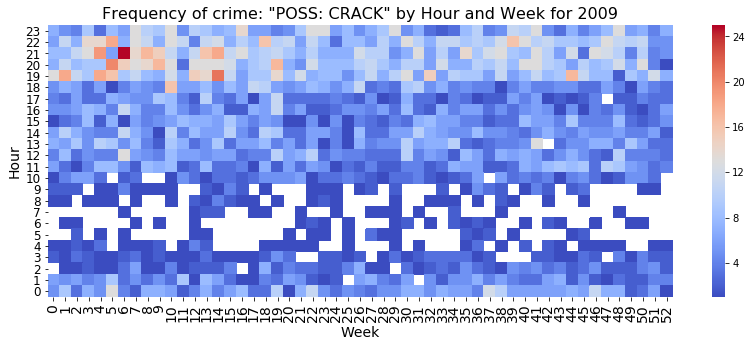

In [23]:
plot_crime_freq_heatmap('POSS: CRACK', 'Week', 'Hour', weeks, hours, 2009, figsize=(14,5))

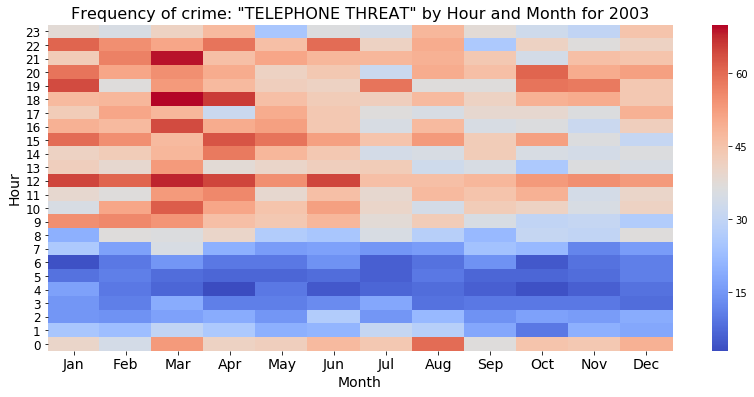

In [24]:
plot_crime_freq_heatmap('TELEPHONE THREAT', 'Month', 'Hour', months, hours, 2003)

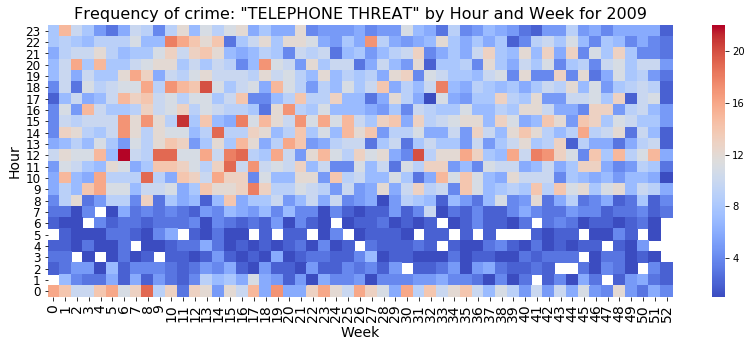

In [25]:
plot_crime_freq_heatmap('TELEPHONE THREAT', 'Week', 'Hour', weeks, hours, 2009, figsize=(14,5))

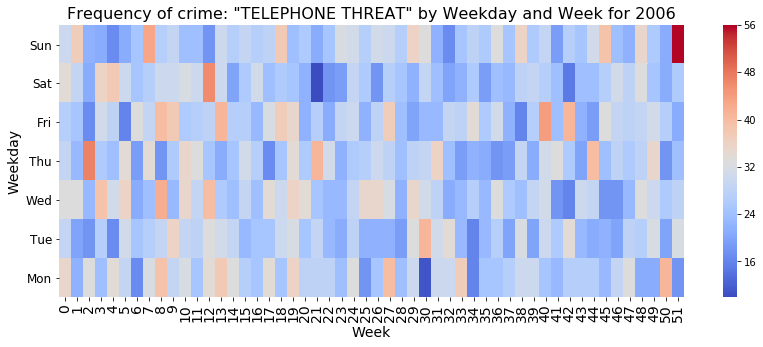

In [26]:
plot_crime_freq_heatmap('TELEPHONE THREAT', 'Week', 'Weekday', weeks, weekdays, 2006, figsize=(14,5))

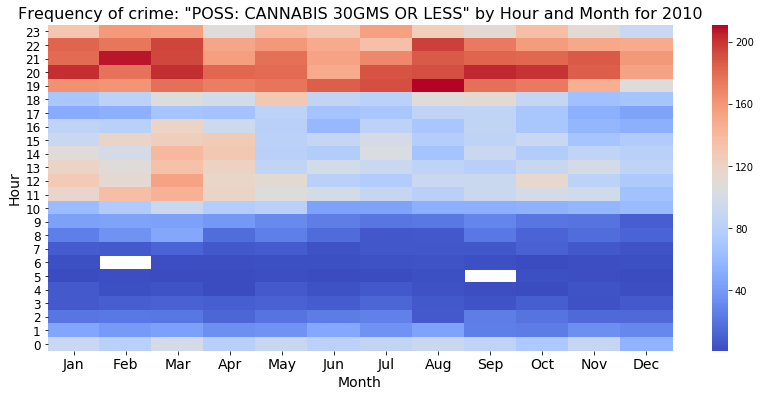

In [27]:
plot_crime_freq_heatmap('POSS: CANNABIS 30GMS OR LESS', 'Month', 'Hour', months, hours, 2010)

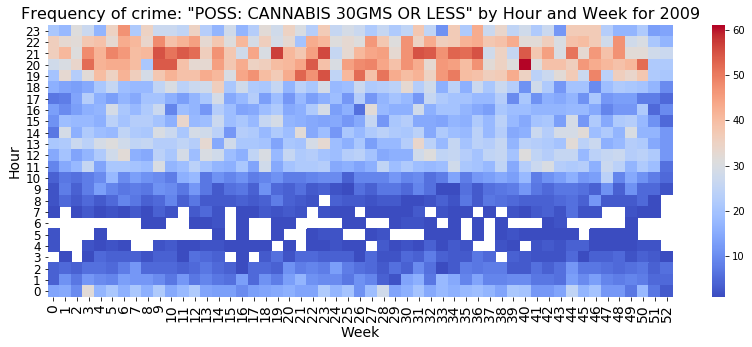

In [28]:
plot_crime_freq_heatmap('POSS: CANNABIS 30GMS OR LESS', 'Week', 'Hour', weeks, hours, 2009, figsize=(14,5))

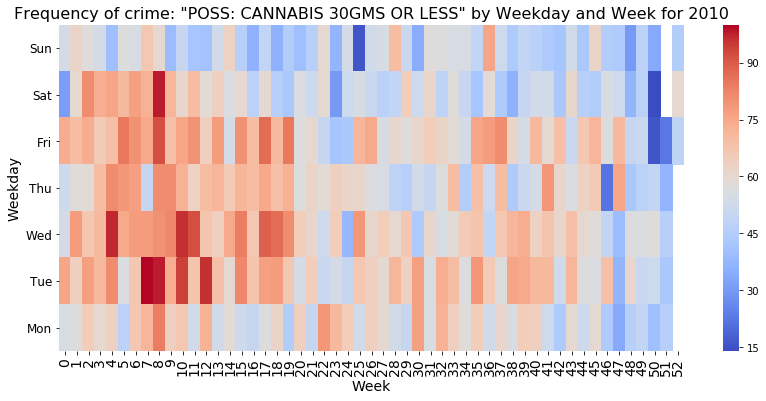

In [29]:
plot_crime_freq_heatmap('POSS: CANNABIS 30GMS OR LESS', 'Week', 'Weekday', weeks, weekdays, 2010)

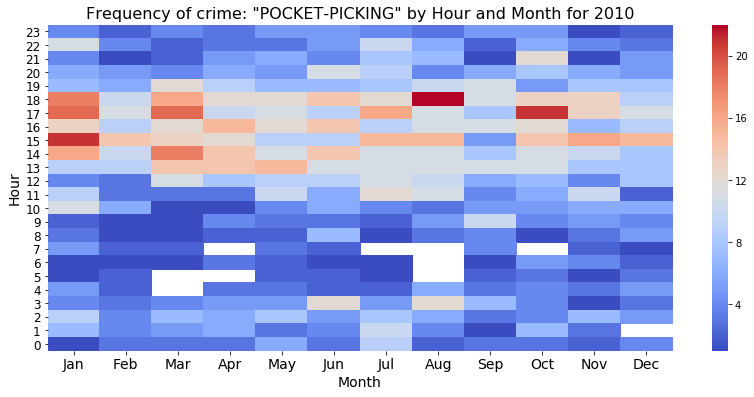

In [30]:
plot_crime_freq_heatmap('POCKET-PICKING', 'Month', 'Hour', months, hours, 2010)

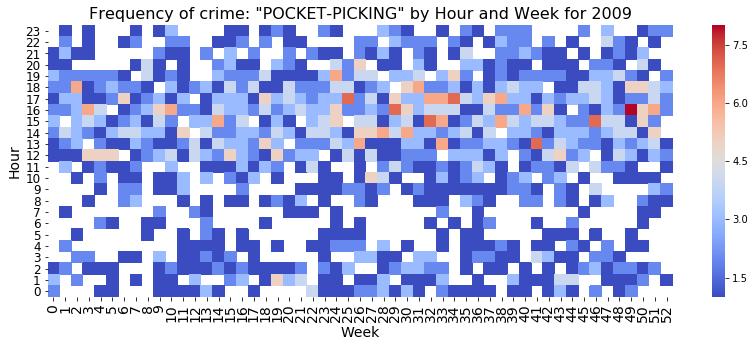

In [31]:
plot_crime_freq_heatmap('POCKET-PICKING', 'Week', 'Hour', weeks, hours, 2009, figsize=(14,5))

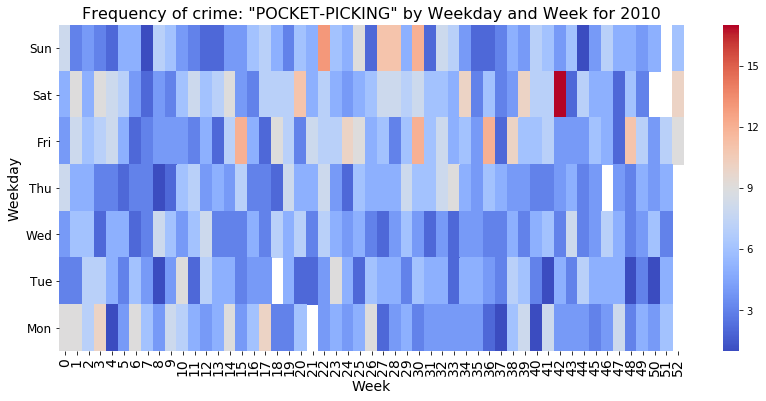

In [32]:
plot_crime_freq_heatmap('POCKET-PICKING', 'Week', 'Weekday', weeks, weekdays, 2010)

In [33]:
query = chi_crimes['Description'].value_counts()
query[(query > 5000) & (query < 10000)]

ATTEMPT: STRONGARM-NO WEAPON               9888
FIRST DEGREE MURDER                        9466
AGGRAVATED VEHICULAR HIJACKING             9464
CRIMINAL SEXUAL ABUSE                      9109
OTHER OFFENSE                              9012
POSSESSION OF DRUG EQUIPMENT               8791
THEFT OF LOST/MISLAID PROP                 8514
UNLAWFUL USE OTHER DANG WEAPON             8481
ATTEMPT: ARMED-HANDGUN                     8311
FINANCIAL IDENTITY THEFT $300 AND UNDER    7696
COUNTERFEIT CHECK                          7598
VEHICLE TITLE/REG OFFENSE                  7563
OTHER WEAPONS VIOLATION                    7351
BY FIRE                                    7301
PUBLIC INDECENCY                           7291
LICENSE VIOLATION                          6975
OTHER CRIME AGAINST PERSON                 6955
ENDANGERING LIFE/HEALTH CHILD              6689
BOMB THREAT                                6565
TO STATE SUP PROP                          5763
RESIST/OBSTRUCT/DISARM OFFICER          

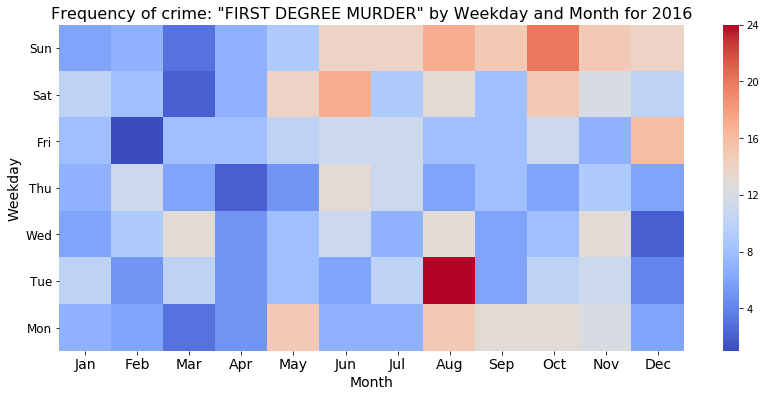

In [34]:
plot_crime_freq_heatmap('FIRST DEGREE MURDER', 'Month', 'Weekday', months, weekdays, 2016)

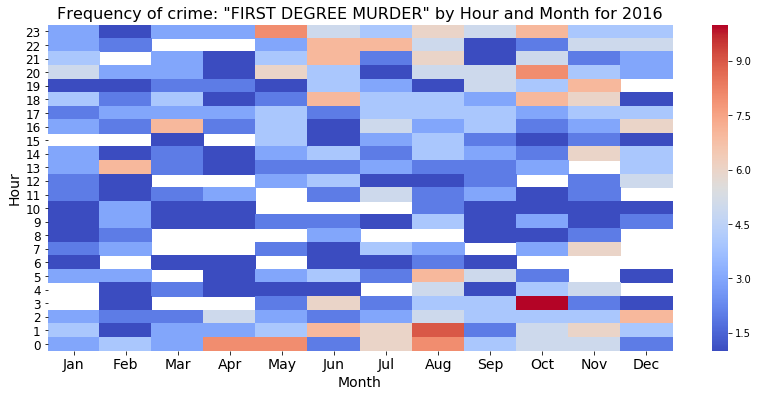

In [35]:
plot_crime_freq_heatmap('FIRST DEGREE MURDER', 'Month', 'Hour', months, hours, 2016)

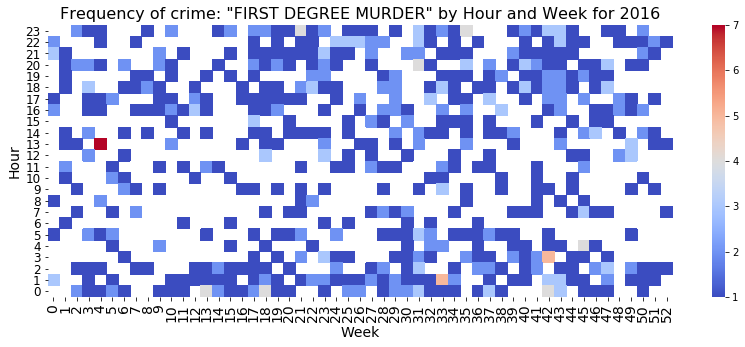

In [36]:
plot_crime_freq_heatmap('FIRST DEGREE MURDER', 'Week', 'Hour', weeks, hours, 2016, figsize=(14,5))

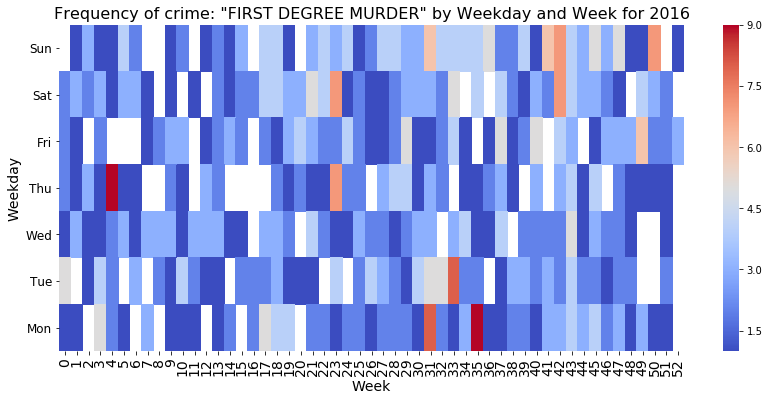

In [37]:
plot_crime_freq_heatmap('FIRST DEGREE MURDER', 'Week', 'Weekday', weeks, weekdays, 2016)

In [ ]:
chi_crimes['Primary Type'].value_counts()

In [ ]:
map_counts(chi_crimes, 'THEFT', '2012-01-01', '2012-12-31', scale=0.6, figsize=(10,10))

In [ ]:
map_counts(chi_crimes, 'THEFT', '2001-01-01', '2009-12-31', scale=0.6, figsize=(10,10))

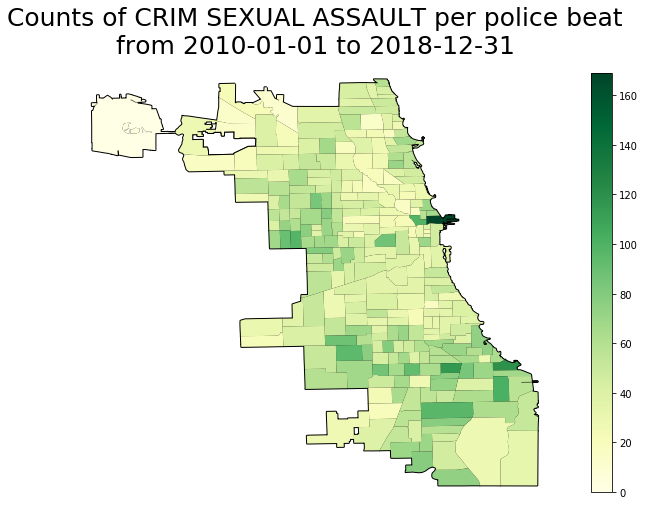

In [150]:
map_counts(chi_crimes, 'CRIM SEXUAL ASSAULT', '2010-01-01', '2018-12-31', scale=0.6, figsize=(10,10))

That's pretty wild. I'm not sure why the magnificent mile is such an outlier regarding criminal sexual assault. Let's take a closer look. 

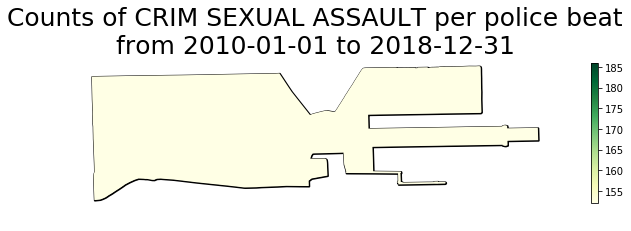

In [87]:
map_counts(chi_crimes[chi_crimes['Beat'] == 1834], 'CRIM SEXUAL ASSAULT', gdf=beats[beats['beat_num'] == 1834], 
           start_date='2010-01-01', end_date='2018-12-31', scale=0.2)

In [91]:
query = chi_crimes.loc[(chi_crimes['Beat'] == 1834) & (chi_crimes['Primary Type'] == 'CRIM SEXUAL ASSAULT'), 'IUCR'].value_counts()
query[query > 0]

0281    182
0265     15
0291      7
0261      5
0264      2
0273      2
0266      2
0263      1
Name: IUCR, dtype: int64

In [70]:
chi_crimes[chi_crimes['Primary Type'] == 'CRIM SEXUAL ASSAULT']['IUCR'].value_counts()

0281    15231
0265     4460
0266     2709
0261     1697
0291     1246
0263     1049
0264      305
0275      247
0273      172
0271      147
0274       49
0262       33
0272        3
1153        0
1155        0
1156        0
1160        0
1154        0
9901        0
1152        0
1185        0
1151        0
1150        0
1170        0
1230        0
1195        0
1200        0
1205        0
1206        0
1210        0
        ...  
2080        0
2090        0
2091        0
2092        0
2021        0
2019        0
1754        0
2018        0
1755        0
1780        0
1790        0
1791        0
1792        0
1811        0
1812        0
1821        0
1822        0
1840        0
1850        0
1860        0
1900        0
2010        0
2011        0
2012        0
2013        0
2014        0
2015        0
2016        0
2017        0
0110        0
Name: IUCR, Length: 401, dtype: int64

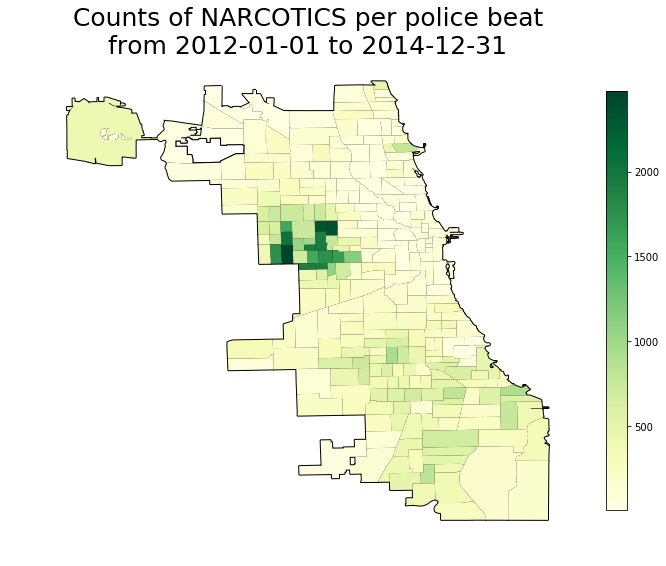

In [50]:
map_counts(chi_crimes, 'NARCOTICS', '2012-01-01', '2014-12-31', scale=0.6, figsize=(10,10))

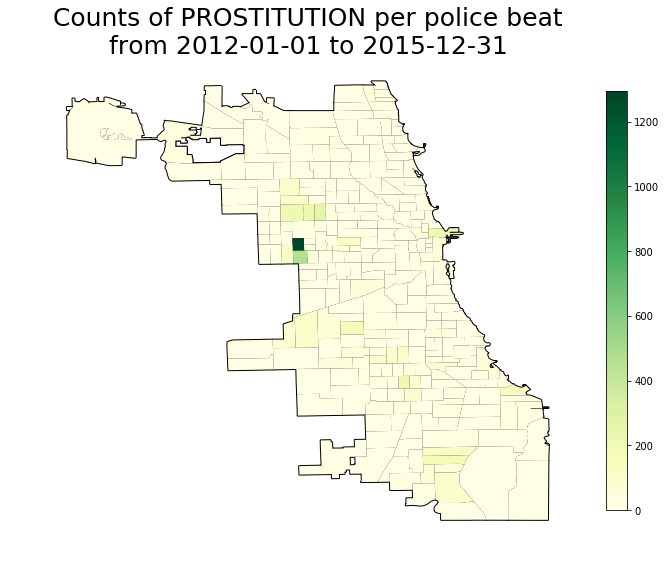

In [34]:
map_counts(chi_crimes, 'PROSTITUTION', '2012-01-01', '2015-12-31', scale=0.6, figsize=(10,10))

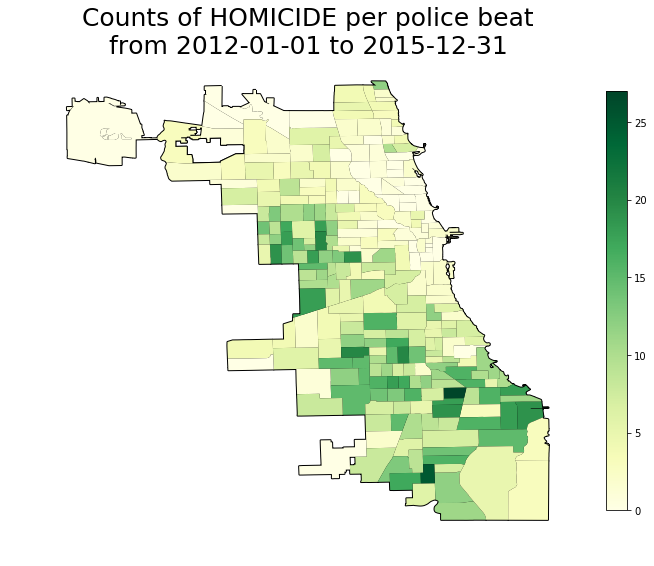

In [33]:
map_counts(chi_crimes, 'HOMICIDE', '2012-01-01', '2015-12-31', scale=0.6, figsize=(10,10))

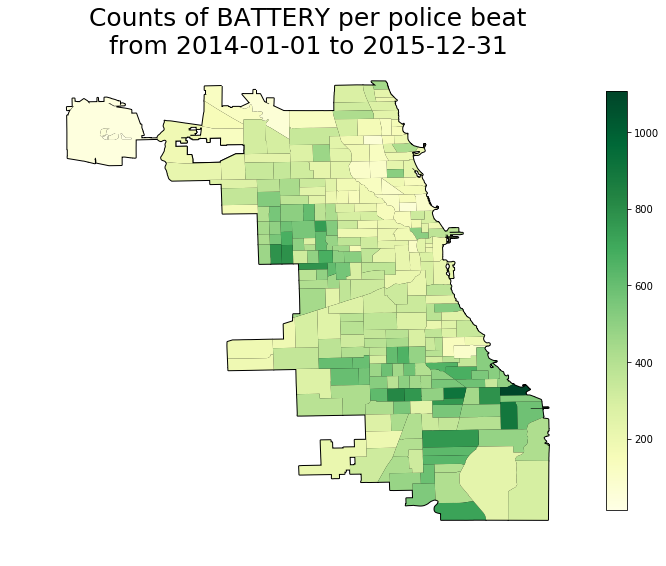

In [25]:
map_counts(chi_crimes, 'BATTERY', '2014-01-01', '2015-12-31', scale=0.6, figsize=(10,10))

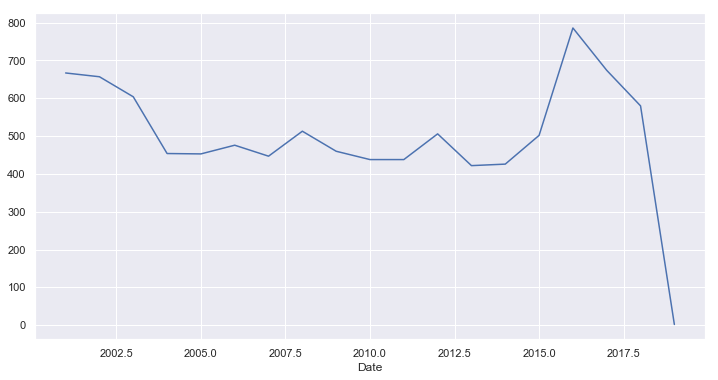

In [83]:
fig, ax = plt.subplots(figsize=(12,6))
tmp = chi_crimes.loc[chi_crimes['Primary Type'] == 'HOMICIDE'].copy()
tmp.set_index('Date', inplace=True)
tmp[['ID']].groupby([tmp.index.year]).count().plot(ax=ax, legend=None)
# plt.show()
# tmp.index.year